In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DiffusionSampler:
    """Handles sampling/inference from the trained diffusion model"""
    def __init__(self, model, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.model = model
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Linear beta schedule (same as training)
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Precompute values for sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # Posterior variance for DDPM sampling
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    
    @torch.no_grad()
    def ddpm_sample_step(self, x_t, t_int, current_age, target_age, reference_img):
        """Single DDPM sampling step"""
        batch_size = x_t.shape[0]
        
        # Create timestep tensor
        t = torch.full((batch_size,), t_int, dtype=torch.long, device=self.device)
        
        # Get model prediction
        noise_pred = self.model(x_t, t, current_age, target_age, reference_img)
        
        # Get parameters for this timestep
        alpha_t = self.alphas[t_int]
        alpha_cumprod_t = self.alphas_cumprod[t_int]
        beta_t = self.betas[t_int]
        
        # Predict x_0 from x_t and predicted noise
        sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1.0 - alpha_cumprod_t)
        
        # x_0 = (x_t - sqrt(1-alpha_cumprod) * noise) / sqrt(alpha_cumprod)
        pred_x0 = (x_t - sqrt_one_minus_alpha_cumprod_t * noise_pred) / sqrt_alpha_cumprod_t
        pred_x0 = torch.clamp(pred_x0, -1, 1)
        
        if t_int > 0:
            # Sample x_{t-1} using the posterior q(x_{t-1} | x_t, x_0)
            alpha_cumprod_prev = self.alphas_cumprod_prev[t_int]
            
            # Posterior mean coefficient for x_0
            coef_x0 = beta_t * torch.sqrt(alpha_cumprod_prev) / (1.0 - alpha_cumprod_t)
            # Posterior mean coefficient for x_t
            coef_xt = torch.sqrt(alpha_t) * (1.0 - alpha_cumprod_prev) / (1.0 - alpha_cumprod_t)
            
            posterior_mean = coef_x0 * pred_x0 + coef_xt * x_t
            
            # Add noise scaled by posterior variance
            posterior_variance = self.posterior_variance[t_int]
            noise = torch.randn_like(x_t)
            x_t_minus_1 = posterior_mean + torch.sqrt(posterior_variance) * noise
        else:
            # At t=0, return the predicted x_0 directly
            x_t_minus_1 = pred_x0
        
        return x_t_minus_1
    
    @torch.no_grad()
    def sample(self, reference_img, current_age, target_age, num_steps=None):
        """
        Generate aged/de-aged image
        
        Args:
            reference_img: Input image tensor (1, 3, H, W), normalized to [-1, 1]
            current_age: Current age tensor (1,)
            target_age: Target age tensor (1,)
            num_steps: Number of diffusion steps (default: self.num_timesteps)
        
        Returns:
            Generated image tensor (1, 3, H, W)
        """
        if num_steps is None:
            num_steps = self.num_timesteps
        
        # Start from random noise
        x_t = torch.randn_like(reference_img).to(self.device)
        
        # Reverse diffusion process
        for i in reversed(range(num_steps)):
            x_t = self.ddpm_sample_step(x_t, i, current_age, target_age, reference_img)
            
            if i % 100 == 0:
                print(f"Sampling step {i}/{num_steps}, x_t range: [{x_t.min():.3f}, {x_t.max():.3f}]")
        
        return x_t


In [3]:
def load_checkpoint(checkpoint_path, model, device='cuda'):
    """Load trained model checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    # print(f"Cross-sectional loss: {checkpoint['loss_cross']:.4f}")
    print(f"Longitudinal loss: {checkpoint['loss_long']:.4f}")
    return model


def load_and_preprocess_image(image_path, size=256):
    """Load and preprocess image for the model"""
    transform = transforms.Compose([
        transforms.Resize((size, size), Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    
    # Handle both regular images and .npy files
    if image_path.endswith('.npy'):
        image = np.load(image_path)
        
        # Convert to uint8
        if image.dtype in [np.float32, np.float64]:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        elif image.dtype != np.uint8:
            image = image.astype(np.uint8)
        
        # Handle channel order
        if image.ndim == 3:
            if image.shape[0] in [1, 3]:  # (C, H, W) format
                image = np.transpose(image, (1, 2, 0))
        elif image.ndim == 2:  # Grayscale
            image = np.expand_dims(image, axis=-1)
        
        # Convert to PIL
        image = np.ascontiguousarray(image)
        if image.shape[-1] == 1:
            image = Image.fromarray(image.squeeze(), mode='L').convert('RGB')
        else:
            image = Image.fromarray(image, mode='RGB')
    else:
        image = Image.open(image_path).convert('RGB')
    
    return transform(image).unsqueeze(0)  # Add batch dimension


def denormalize_image(tensor):
    """Convert normalized tensor back to displayable image"""
    # tensor: (1, 3, H, W) in range [-1, 1]
    img = tensor.squeeze(0).cpu()
    img = (img + 1) / 2  # [-1, 1] -> [0, 1]
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    return img


def visualize_age_transformation(original_img, generated_img, current_age, target_age, save_path=None):
    """Visualize original and generated images side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original (Age: {current_age})', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(generated_img)
    axes[1].set_title(f'Generated (Age: {target_age})', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()

In [4]:
def test_age_transformation(
    checkpoint_path,
    image_path,
    current_age,
    target_age,
    output_path='age_transformation_result.png',
    device='cuda'
):
    """
    Complete testing pipeline
    
    Args:
        checkpoint_path: Path to saved model checkpoint
        image_path: Path to input image
        current_age: Current age of person in image
        target_age: Desired target age
        output_path: Where to save the result
        device: 'cuda' or 'cpu'
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize model
    from diffusion_3 import AgeTransformationDiffusion  # Import your model
    model = AgeTransformationDiffusion(max_age=120).to(device)
    
    # Load checkpoint
    model = load_checkpoint(checkpoint_path, model, device)
    
    # Initialize sampler
    sampler = DiffusionSampler(model, device=device)
    
    # Load and preprocess image
    print(f"\nLoading image: {image_path}")
    img_tensor = load_and_preprocess_image(image_path).to(device)
    
    # Prepare ages
    current_age_tensor = torch.tensor([current_age], dtype=torch.long, device=device)
    target_age_tensor = torch.tensor([target_age], dtype=torch.long, device=device)
    
    # Generate aged/de-aged image
    print(f"\nGenerating transformation: {current_age} -> {target_age} years old")
    print("This may take a few minutes...")
    
    generated_tensor = sampler.sample(
        reference_img=img_tensor,
        current_age=current_age_tensor,
        target_age=target_age_tensor,
        num_steps=1000  # Use fewer steps (e.g., 250) for faster inference
    )
    
    # Convert to displayable format
    original_img = denormalize_image(img_tensor)
    generated_img = denormalize_image(generated_tensor)
    
    # Visualize results
    visualize_age_transformation(
        original_img, 
        generated_img, 
        current_age, 
        target_age,
        save_path=output_path
    )
    
    print("\nDone!")
    return generated_img

Using device: cuda:1


/tmp/ipykernel_553768/1842653083.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 39
Longitudinal loss: 0.0082

Loading image: /projects/standard/csci5561/shared/G8/data/face_age_Numpy/5261_027.npy

Generating transformation: 27 -> 42 years old
This may take a few minutes...


/tmp/ipykernel_553768/1842653083.py:45: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='RGB')


Sampling step 900/1000, x_t range: [-4.244, 4.311]
Sampling step 800/1000, x_t range: [-4.498, 4.283]
Sampling step 700/1000, x_t range: [-4.382, 4.636]
Sampling step 600/1000, x_t range: [-4.567, 4.834]
Sampling step 500/1000, x_t range: [-4.130, 4.909]
Sampling step 400/1000, x_t range: [-4.165, 4.014]
Sampling step 300/1000, x_t range: [-3.549, 4.000]
Sampling step 200/1000, x_t range: [-2.920, 3.146]
Sampling step 100/1000, x_t range: [-2.066, 2.163]
Sampling step 0/1000, x_t range: [-1.000, 1.000]


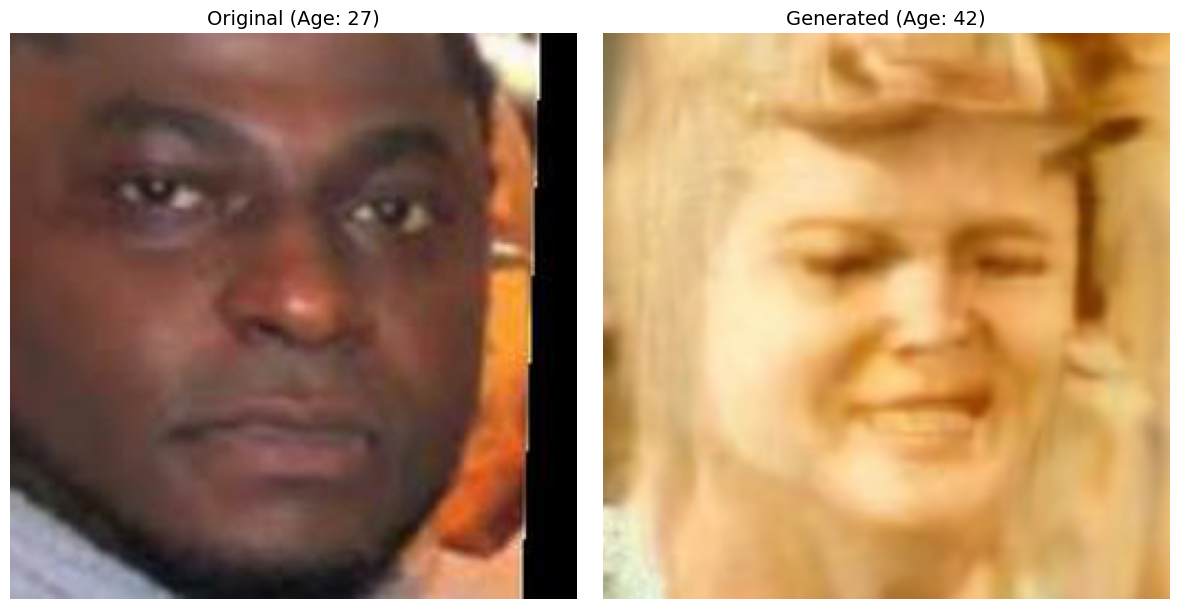


Done!


array([[[0.49210533, 0.42319727, 0.25338364],
        [0.50368613, 0.43277156, 0.2692968 ],
        [0.5128419 , 0.43979147, 0.2775644 ],
        ...,
        [0.86032885, 0.64764667, 0.32100672],
        [0.87412393, 0.6516464 , 0.33005935],
        [0.8772148 , 0.6671529 , 0.3348986 ]],

       [[0.50060815, 0.42799228, 0.25678557],
        [0.50679284, 0.43404207, 0.26627564],
        [0.5171892 , 0.44115087, 0.27534807],
        ...,
        [0.8774959 , 0.65889513, 0.3210339 ],
        [0.89033467, 0.6604761 , 0.32815975],
        [0.89292634, 0.6751194 , 0.33437014]],

       [[0.49935776, 0.430871  , 0.2598253 ],
        [0.5051508 , 0.43513018, 0.27214068],
        [0.5123042 , 0.4410799 , 0.27889982],
        ...,
        [0.89307344, 0.6665875 , 0.322298  ],
        [0.9002212 , 0.6717787 , 0.32905602],
        [0.9070978 , 0.6861621 , 0.33823246]],

       ...,

       [[0.7304486 , 0.7313272 , 0.60565054],
        [0.7370042 , 0.7435932 , 0.6149998 ],
        [0.7450529 , 0

In [5]:
# Example: Age someone by 10 years
test_age_transformation(
    checkpoint_path='epochs_attempt3_larger/checkpoint_epoch_39.pt',
    image_path="/projects/standard/csci5561/shared/G8/data/face_age_Numpy/5261_027.npy",  # or .npy file
    current_age=27,
    target_age=42,  # Age by 10 years
    output_path=None,
    device='cuda:1'
)

# Example: De-age someone by 20 years
# test_age_transformation(
#     checkpoint_path='epochs_attempt1/checkpoint_epoch_95.pt',
#     image_path='path/to/your/test_image.jpg',
#     current_age=50,
#     target_age=30,
#     output_path='de_aged_by_20_years.png',
#     device='cuda'
# )